# ノック51 - 物流に関するデータの読み込み・整形

In [1]:
import pandas as pd
import random

本章では、物流の最適化を分析していく。  
各倉庫から各工場への部品の配送コスト最適化を目的とする。  
  
まずは、各データを読み込む。

In [2]:
factories = pd.read_csv("tbl_factory.csv")
factories

,FCID,FCName,FCDemand,FCRegion
0,FC00001,東京工場,28,関東
1,FC00002,木更津工場,29,関東
2,FC00003,多摩工場,31,関東
3,FC00004,横須賀工場,25,関東
4,FC00005,仙台工場,21,東北
5,FC00006,山形工場,30,東北
6,FC00007,那須工場,25,東北
7,FC00008,青森工場,16,東北


In [3]:
warehouses = pd.read_csv("tbl_warehouse.csv")
warehouses

,WHID,WHName,WHSupply,WHRegion
0,WH00001,杉並倉庫,35,関東
1,WH00002,品川倉庫,41,関東
2,WH00003,豊洲倉庫,42,関東
3,WH00004,郡山倉庫,60,東北
4,WH00005,仙台倉庫,72,東北
5,WH00006,山形倉庫,65,東北


In [4]:
cost = pd.read_csv("rel_cost.csv")
cost

,RCostID,FCID,WHID,Cost
0,1,FC00001,WH00001,0.4
1,2,FC00001,WH00002,0.8
2,3,FC00001,WH00003,1.5
3,4,FC00002,WH00001,0.9
4,5,FC00002,WH00002,0.8
5,6,FC00002,WH00003,1.6
6,7,FC00003,WH00001,1.2
7,8,FC00003,WH00002,1.3
8,9,FC00003,WH00003,1.5
9,10,FC00004,WH00001,0.8


これは、例えば1列目はWH00001倉庫からFC00001工場までのコストが0.4という事を表している。

In [5]:
# 2019年1月1日 ～ 2019年12月31日の配送データ

trans = pd.read_csv("tbl_transaction.csv")
trans

,TRID,TransactionDate,ToFC,FromWH,Quantity
0,0,2019-01-01 02:11:10,FC00004,WH00003,33
1,1,2019-01-01 06:12:42,FC00007,WH00006,19
2,2,2019-01-01 06:32:32,FC00006,WH00004,31
3,3,2019-01-01 07:17:06,FC00002,WH00003,18
4,4,2019-01-01 07:52:18,FC00001,WH00002,30
...,...,...,...,...,...
3995,3995,2019-12-31 11:27:51,FC00007,WH00006,29
3996,3996,2019-12-31 17:10:21,FC00002,WH00003,35
3997,3997,2019-12-31 19:35:07,FC00003,WH00001,36
3998,3998,2019-12-31 21:45:07,FC00005,WH00005,34


これは、例えば1列目はWH00003倉庫からFC00004工場まで33個配送したという事を表している。

ここで、transとcostを結合する。

transのToFCとFromWHが、costのFCIDとWHIDに対応している。

In [6]:
join_data = pd.merge(trans, cost, left_on = ["ToFC", "FromWH"],right_on = ["FCID", "WHID"])
del join_data["TRID"]
del join_data["RCostID"]
join_data

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1
1,2019-01-04 04:43:52,FC00004,WH00003,25,FC00004,WH00003,1.1
2,2019-01-06 07:01:42,FC00004,WH00003,37,FC00004,WH00003,1.1
3,2019-01-08 08:47:05,FC00004,WH00003,24,FC00004,WH00003,1.1
4,2019-01-09 00:12:40,FC00004,WH00003,33,FC00004,WH00003,1.1
...,...,...,...,...,...,...,...
3995,2019-12-22 11:27:54,FC00008,WH00006,22,FC00008,WH00006,1.3
3996,2019-12-26 12:45:17,FC00008,WH00006,26,FC00008,WH00006,1.3
3997,2019-12-27 03:04:18,FC00008,WH00006,35,FC00008,WH00006,1.3
3998,2019-12-28 02:32:34,FC00008,WH00006,14,FC00008,WH00006,1.3


次に、工場のデータを付与する。

In [7]:
join_data = pd.merge(join_data, factories, on = "FCID")
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,横須賀工場,25,関東
1,2019-01-04 04:43:52,FC00004,WH00003,25,FC00004,WH00003,1.1,横須賀工場,25,関東
2,2019-01-06 07:01:42,FC00004,WH00003,37,FC00004,WH00003,1.1,横須賀工場,25,関東
3,2019-01-08 08:47:05,FC00004,WH00003,24,FC00004,WH00003,1.1,横須賀工場,25,関東
4,2019-01-09 00:12:40,FC00004,WH00003,33,FC00004,WH00003,1.1,横須賀工場,25,関東


さらに倉庫データも付与する。  

In [8]:
join_data = pd.merge(join_data, warehouses, on = "WHID")
del join_data["FCRegion"]
join_data

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,横須賀工場,25,豊洲倉庫,42,関東
1,2019-01-04 04:43:52,FC00004,WH00003,25,FC00004,WH00003,1.1,横須賀工場,25,豊洲倉庫,42,関東
2,2019-01-06 07:01:42,FC00004,WH00003,37,FC00004,WH00003,1.1,横須賀工場,25,豊洲倉庫,42,関東
3,2019-01-08 08:47:05,FC00004,WH00003,24,FC00004,WH00003,1.1,横須賀工場,25,豊洲倉庫,42,関東
4,2019-01-09 00:12:40,FC00004,WH00003,33,FC00004,WH00003,1.1,横須賀工場,25,豊洲倉庫,42,関東
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2019-12-14 19:22:30,FC00008,WH00004,32,FC00008,WH00004,1.5,青森工場,16,郡山倉庫,60,東北
3996,2019-12-24 02:47:46,FC00008,WH00004,21,FC00008,WH00004,1.5,青森工場,16,郡山倉庫,60,東北
3997,2019-12-24 05:26:51,FC00008,WH00004,28,FC00008,WH00004,1.5,青森工場,16,郡山倉庫,60,東北
3998,2019-12-28 10:06:16,FC00008,WH00004,17,FC00008,WH00004,1.5,青森工場,16,郡山倉庫,60,東北


不要な列を省く。

In [9]:
del join_data["FCID"]
del join_data["WHID"]
join_data

,TransactionDate,ToFC,FromWH,Quantity,Cost,FCName,FCDemand,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,1.1,横須賀工場,25,豊洲倉庫,42,関東
1,2019-01-04 04:43:52,FC00004,WH00003,25,1.1,横須賀工場,25,豊洲倉庫,42,関東
2,2019-01-06 07:01:42,FC00004,WH00003,37,1.1,横須賀工場,25,豊洲倉庫,42,関東
3,2019-01-08 08:47:05,FC00004,WH00003,24,1.1,横須賀工場,25,豊洲倉庫,42,関東
4,2019-01-09 00:12:40,FC00004,WH00003,33,1.1,横須賀工場,25,豊洲倉庫,42,関東
...,...,...,...,...,...,...,...,...,...,...
3995,2019-12-14 19:22:30,FC00008,WH00004,32,1.5,青森工場,16,郡山倉庫,60,東北
3996,2019-12-24 02:47:46,FC00008,WH00004,21,1.5,青森工場,16,郡山倉庫,60,東北
3997,2019-12-24 05:26:51,FC00008,WH00004,28,1.5,青森工場,16,郡山倉庫,60,東北
3998,2019-12-28 10:06:16,FC00008,WH00004,17,1.5,青森工場,16,郡山倉庫,60,東北


最後に列を分かりやすく並べ替え、行をTransactionDateでソートする。

In [10]:
join_data = join_data.reindex(columns=["TransactionDate","Quantity", "Cost", "ToFC","FCName","FCDemand","FromWH","WHName","WHSupply","WHRegion"])
join_data.sort_values("TransactionDate", inplace = True)
join_data.reset_index(drop = True, inplace = True)
join_data.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
1,2019-01-01 06:12:42,19,1.3,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
3,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8,FC00001,東京工場,28,WH00002,品川倉庫,41,関東


次に、関東と東北で分ける。

In [11]:
kanto = join_data.loc[join_data["WHRegion"] == "関東"]
kanto.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
3,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8,FC00001,東京工場,28,WH00002,品川倉庫,41,関東
7,2019-01-01 09:09:30,12,1.5,FC00001,東京工場,28,WH00003,豊洲倉庫,42,関東
8,2019-01-01 10:52:55,27,1.5,FC00003,多摩工場,31,WH00003,豊洲倉庫,42,関東


In [12]:
tohoku = join_data.loc[join_data["WHRegion"] == "東北"]
tohoku.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
1,2019-01-01 06:12:42,19,1.3,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
5,2019-01-01 08:56:09,31,0.3,FC00005,仙台工場,21,WH00005,仙台倉庫,72,東北
6,2019-01-01 09:00:15,33,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北
9,2019-01-01 14:12:51,21,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北


# ノック52 - 現状の輸送量・コストを確認

関東、東北それぞれで1年にかかったコストを計算する。

In [13]:
print("関東支社の総コスト: " + str(kanto["Cost"].sum()) + "万円")
print("東北支社の総コスト: " + str(tohoku["Cost"].sum()) + "万円")

関東支社の総コスト: 2189.3万円
東北支社の総コスト: 2062.0万円


次にそれぞれの総部品輸送個数を計算する。

In [14]:
print("関東支社の総部品輸送個数: " + str(kanto["Quantity"].sum()) + "個")
print("東北支社の総部品輸送個数: " + str(tohoku["Quantity"].sum()) + "個")

関東支社の総部品輸送個数: 49146個
東北支社の総部品輸送個数: 50214個


次に部品一つあたりの輸送コストを計算する。

In [15]:
print("関東支社の部品一つあたりの輸送コスト: " + str(round(kanto["Cost"].sum() / kanto["Quantity"].sum() * 10000)) + "円")
print("東北支社の部品一つあたりの輸送コスト: " + str(round(tohoku["Cost"].sum() / tohoku["Quantity"].sum() * 10000)) + "円")

関東支社の部品一つあたりの輸送コスト: 445.0円
東北支社の部品一つあたりの輸送コスト: 411.0円


最後に、輸送コストの平均を算出する。

In [16]:
print("関東支社の輸送コストの平均: " + str(f'{kanto["Cost"].mean():.3f}') + "万円")
print("東北支社の輸送コストの平均: " + str(f'{tohoku["Cost"].mean():.3f}') + "万円")

関東支社の輸送コストの平均: 1.095万円
東北支社の輸送コストの平均: 1.031万円


関東支社・東北支社の平均輸送コストはほぼ同じという事が分かる。  
以上から、東北支社の方がより低いコストで多くの部品を運べている事が分かる。

# ノック53 - ネットワークの可視化

networkxを用いて可視化していく。

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

まずは単純なグラフを作成する。

In [18]:
G = nx.Graph()
G.add_nodes_from(["nodeA","nodeB","nodeC"])
G.add_edges_from([("nodeA","nodeB"),("nodeA","nodeC"),("nodeB","nodeC")])

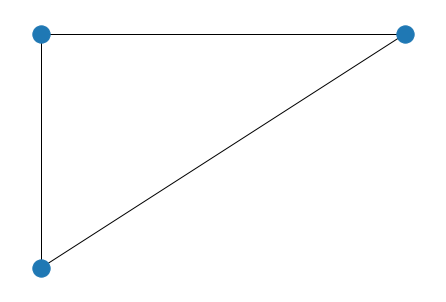

In [19]:
nx.draw(G,pos ={"nodeA":(0,0),"nodeB":(0,0.5),"nodeC":(0.5,0.5)})
plt.show()

# ノック54 - ネットワークにノードを追加

ノック53に、nodeDを追加し、ラベルを表示する。

In [20]:
G.add_node("nodeD")
G.add_edge("nodeA","nodeD")

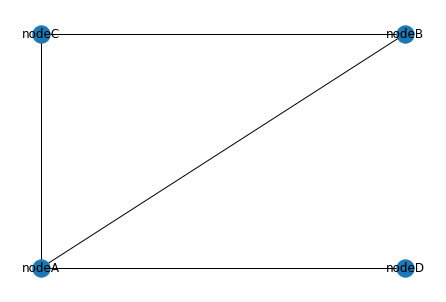

In [21]:
nx.draw(G,pos ={"nodeA":(0,0),"nodeB":(0.5,0.5),"nodeC":(0,0.5),"nodeD":(0.5,0)},with_labels = True)
plt.show()

# ノック55 - ルートの重みづけ(ここから自身の解答)

予め用意されている2つのcsvファイルを用いて、ネットワークに重みづけをする。

In [22]:
# 2つのファイルの読み込み

network_pos = pd.read_csv("network_pos.csv")
network_pos

,A,B,C,D,E
0,0,0,2,2,1
1,0,2,0,2,1


In [23]:
network_weight = pd.read_csv("network_weight.csv")
network_weight

,A,B,C,D,E
0,0.639921,0.143353,0.944669,0.521848,0.000000
1,0.264556,0.000000,0.456150,0.568434,0.000000
2,0.617635,0.612096,0.616934,0.943748,0.000000
3,0.000000,0.000000,0.697631,0.060225,0.666767
4,0.670638,0.210383,0.000000,0.315428,0.000000


nodeEを付け足して、新しくネットワークを作り直す。

In [25]:
#　ノードのリスト
nodes = ["nodeA","nodeB","nodeC","nodeD","nodeE"]

# ノードの組み合わせを作成
import itertools
pair_original = []
for pair in itertools.combinations(nodes, 2):
    pair_original.append(pair)

#("nodeA","nodeD"),("nodeB","nodeC")は必要無いので削除
pair_original.remove(("nodeA","nodeD"))
pair_original.remove(("nodeB","nodeC"))

#ネットワークの作成
G_weight = nx.Graph()
G_weight.add_nodes_from(nodes)
G_weight.add_edges_from(pair_original)

In [26]:
# nework_posのcsvファイルから、各点のポジション情報を抽出

pos = {}    
for i in range(0,5):
    pos[nodes[i]] = network_pos[network_pos.columns[i]]
pos

{'nodeA': 0    0
 1    0
 Name: A, dtype: int64,
 'nodeB': 0    0
 1    2
 Name: B, dtype: int64,
 'nodeC': 0    2
 1    0
 Name: C, dtype: int64,
 'nodeD': 0    2
 1    2
 Name: D, dtype: int64,
 'nodeE': 0    1
 1    1
 Name: E, dtype: int64}

In [27]:
# 次に、network_weightから重みの情報をタプルに代入
# ここでは適当に重みをランダムに抽出して作成。これは、どの重みをどの辺にを入れるかは後程のノックに取り組まないと分からないため。

concat = pd.Series()
for i in network_weight.columns:
    concat = pd.concat([concat,network_weight[i]])
concat_list = list(concat)

C:\Users\Takeshi\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


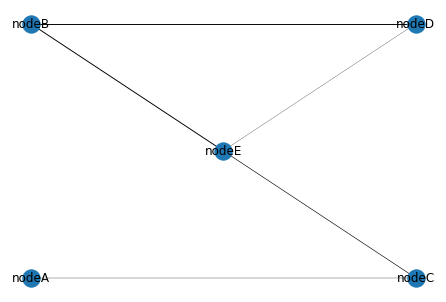

In [28]:
# 先ほどのポジション情報とランダムに抽出した重み情報を用いて描画

nx.draw(G_weight, with_labels = True, pos = pos, width = random.sample(concat_list,9))